# Graded Exercise 4

Graded index (GRIN) lenses focus light with their refractive index distribution.

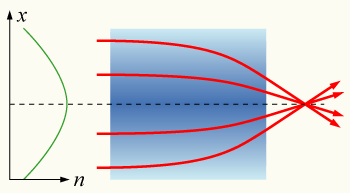

Their refractive index can be defined as: $n(r)=n_{\max }\left(1-\frac{\alpha r^2}{2}\right)$

$n_{\max }$ stands for the maximum refractive index, which is found on the center of the lens, $\alpha$ controls the curvature of the refractive index profile.

Accordingly, the focal length of the lens is $f=\frac{1}{n_{\max } \alpha d}$.

Using the provided initial code,

a) Run BPM simulation for $n_{\max } = 1.05$ and $\alpha = 10^7$. Estimate focal length $f_L$ and FWHM at the focal plane. While varying the sampling z-step of the simulation (dz), track FWHM and $f_L$ values. Suggest an optimal dz for accurate prediction of lens properties while minimizing computational cost.

b) Follow the same steps in (a) for $n_{\max } = 1.05$ and $\alpha = 3 \times 10^7$. Compare the optimal dz with the one in (a). Explain physically and comment on the obtained outcome.

In [79]:
import numpy as np
import matplotlib.pyplot as plt

In [80]:
array_size = 200e-6  
num_pixels = 512  # Resolution

dx = array_size / num_pixels  # Pixel size

wvl = 633e-9
dz = 3e-6


# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

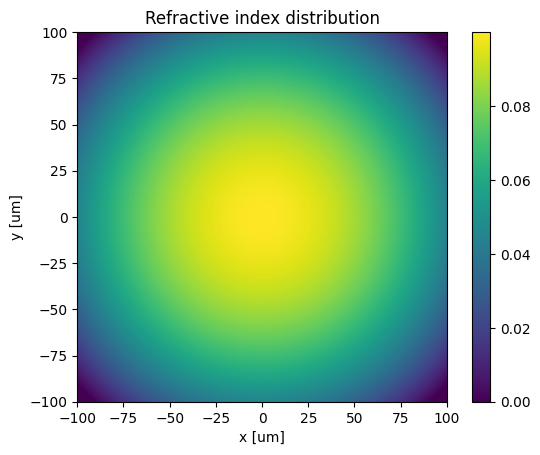

In [81]:
n_max =1.1
alpha =1e7
rho = np.sqrt(X**2+Y**2)
grin_dist = np.maximum(n_max*(1-alpha*rho**2/2)-1,0)
plt.imshow(grin_dist,extent=[-array_size*1e6/2,array_size*1e6/2,-array_size*1e6/2,array_size*1e6/2]); plt.colorbar(); 
plt.title('Refractive index distribution')
plt.xlabel('x [um]')
plt.ylabel('y [um]')  
plt.show()

In [82]:
def angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, num_steps, num_steps_grin, grin_dist, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Define refractive index
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps_grin):
        
        # FILL HERE - apply grin lens refractive index distribution
        U_spectrum = np.fft.fft2(U0*np.exp(1j*grin_dist*k*dz)) * H
                
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)

    for _ in range(num_steps-num_steps_grin):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)        
    return U_list


In [83]:

prop_distance = 1e-3
prop_steps = np.round(prop_distance / dz).astype(int)

prop_distance_grin = 0.18e-3
prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)

U0 = np.ones_like(X)

grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin,grin_dist, True)
array_3d = np.stack(grating_zs)



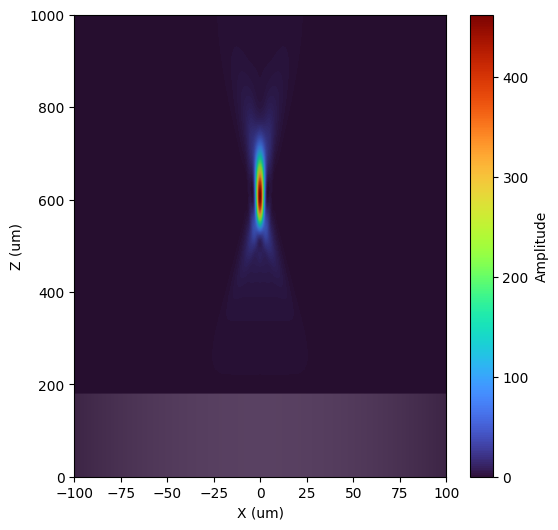

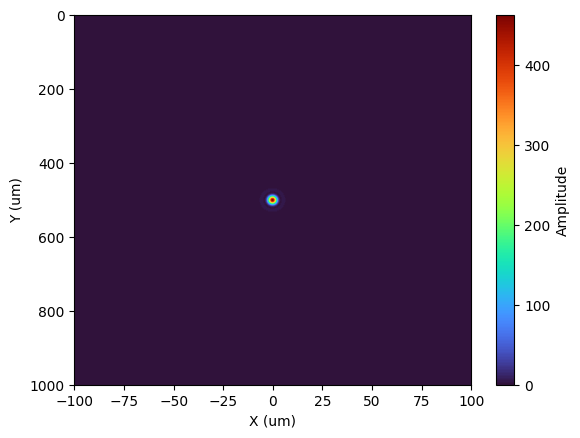

(333, 512, 512)


In [85]:
# Display the grating
plt.figure(figsize=(6, 6))

plt.imshow(np.abs(array_3d[:, 256, :])**2, cmap="turbo",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, prop_distance*1e6,0],alpha= 1.0)
plt.colorbar(label="Amplitude")
grin_dist_1d = grin_dist[256, :]
refractive_distribution = np.ones_like(np.abs(array_3d[:, 256, :]).squeeze())
refractive_distribution[0:prop_steps_grin] = 1+grin_dist_1d[None,:]
plt.imshow(np.flip(refractive_distribution,axis = 0), cmap="gray",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, 0, prop_distance*1e6],alpha= 0.2)

plt.xlabel("X (um)")
plt.ylabel("Z (um)")
plt.show()


plt.imshow(np.abs(array_3d[202, :, :])**2, cmap="turbo",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, prop_distance*1e6,0],alpha= 1.0)
plt.colorbar(label="Amplitude")
plt.xlabel("X (um)")
plt.ylabel("Y (um)")
plt.show()
print(array_3d.shape)

In [37]:
focal_distance = 1/(n_max*alpha*prop_distance_grin)*1e6+prop_distance_grin*1e6
print(focal_distance)


685.050505050505


In [55]:

# Compute the squared amplitude
intensity = np.abs(array_3d[:, 256, :])**2

# Find the maximum value and its index
max_value = np.max(intensity)
max_index = np.unravel_index(np.argmax(intensity), intensity.shape)

print(f"Max Value: {max_value}")
print(f"Max Index: {max_index}")






Max Value: 462.10522255854414
Max Index: (202, 256)


606.6066066066066

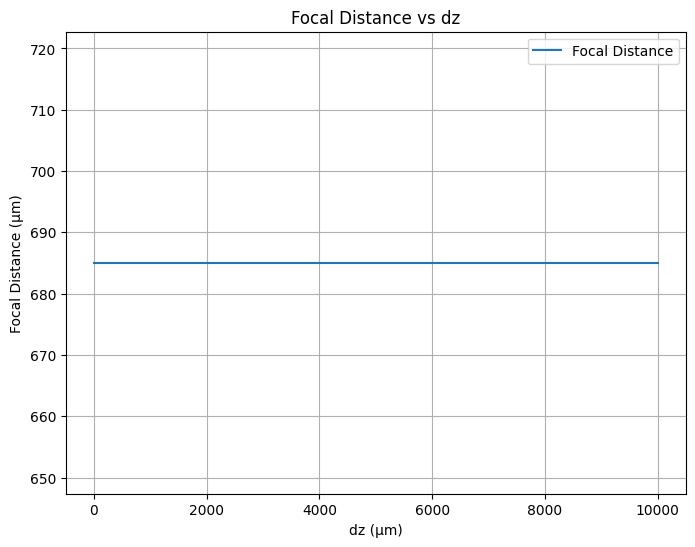

In [20]:

dz_values = np.linspace(1e-6, 10e-6, 50)  # Range of dz values
prop_distance = 1e-3
prop_distance_grin = 0.18e-3

# Compute focal distances for different dz values
focal_distances = 1 / (n_max * alpha * prop_distance_grin) * 1e6 + prop_distance_grin * 1e6

# Plot focal length as a function of dz
plt.figure(figsize=(8, 6))
plt.plot(dz_values * 1e6, focal_distances * np.ones_like(dz_values), label="Focal Distance")
plt.xlabel("dz (µm)")
plt.ylabel("Focal Distance (µm)")
plt.title("Focal Distance vs dz")
plt.legend()
plt.grid()
plt.show()

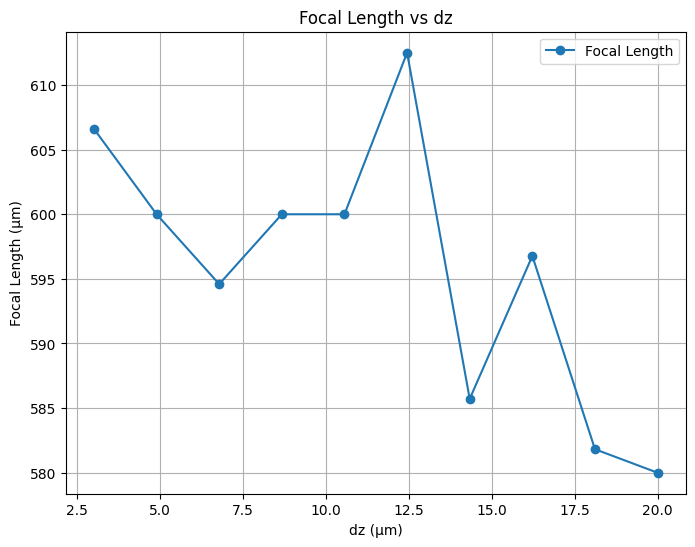

In [70]:


dz_values = np.linspace(3e-6, 20e-6, 10)  # Range of dz values
U0 = np.ones((num_pixels, num_pixels))

# Store focal lengths for each dz value
focal_lengths = []

for dz in dz_values:
    prop_steps = np.round(1e-3 / dz).astype(int)
    prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)
    
    # Run propagation
    grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin, grin_dist, True)
    array_3d = np.stack(grating_zs)
    
    # Compute intensity and find max
    intensity = np.abs(array_3d[:, 256, :])**2
    max_index = np.unravel_index(np.argmax(intensity), intensity.shape)
    
    # Compute focal length
    focal_length = max_index[0]/prop_steps*prop_distance*1e6
    focal_lengths.append(focal_length)

# Plot focal length vs dz
plt.figure(figsize=(8, 6))
plt.plot(dz_values * 1e6, focal_lengths, marker='o', label="Focal Length")
plt.xlabel("dz (µm)")
plt.ylabel("Focal Length (µm)")
plt.title("Focal Length vs dz")
plt.legend()
plt.grid()
plt.show()


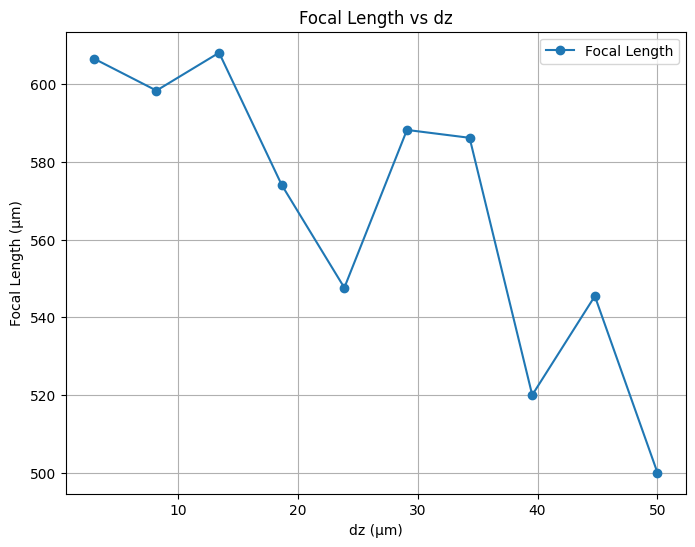

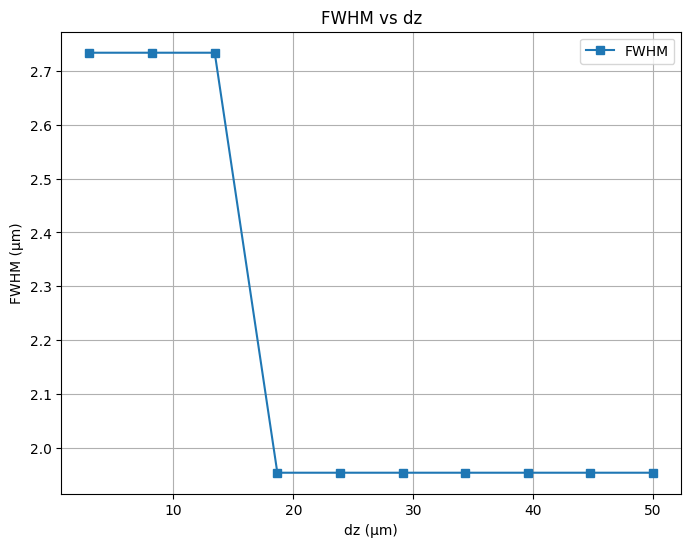

In [90]:
dz_values = np.linspace(3e-6, 50e-6, 10)  # Range of dz values
prop_distance_grin = 0.18e-3
n_max = 0.5
alpha = 3e7
U0 = np.ones((num_pixels, num_pixels))

# Store focal lengths and FWHM for each dz value
focal_lengths = []
fwhm_values = []

def find_fwhm(intensity_line):
    max_val = np.max(intensity_line)
    half_max = max_val / 2
    above_half_max = np.where(intensity_line >= half_max)[0]
    if len(above_half_max) > 1:
        fwhm = (above_half_max[-1] - above_half_max[0]) * dx * 1e6  # Convert to micrometers
    else:
        fwhm = np.nan  # Handle case where FWHM is not well-defined
    return fwhm

for dz in dz_values:
    prop_steps = np.round(1e-3 / dz).astype(int)
    prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)
    
    # Run propagation
    grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin, grin_dist, True)
    array_3d = np.stack(grating_zs)
    
    intensity = np.abs(array_3d[:, 256, :])**2
    max_value = np.max(intensity)
    max_index = np.unravel_index(np.argmax(intensity), intensity.shape)
    
    
    # Compute focal length
    focal_length = max_index[0] / prop_steps * prop_distance * 1e6
    focal_lengths.append(focal_length)
    
    
    # Compute intensity in the x-y plane and find max
    intensity_xy = np.abs(array_3d[max_index[0], :, :])**2  # Intensity at focal plane in x-y plane
    max_index = np.unravel_index(np.argmax(intensity_xy), intensity_xy.shape)
    

    # Compute FWHM at max_index in the x-direction
    fwhm = find_fwhm(intensity_xy[:, max_index[1]])
    fwhm_values.append(fwhm)

# Plot focal length vs dz
plt.figure(figsize=(8, 6))
plt.plot(dz_values * 1e6, focal_lengths, marker='o', label="Focal Length")
plt.xlabel("dz (µm)")
plt.ylabel("Focal Length (µm)")
plt.title("Focal Length vs dz")
plt.legend()
plt.grid()
plt.show()

# Plot FWHM vs dz
plt.figure(figsize=(8, 6))
plt.plot(dz_values * 1e6, fwhm_values, marker='s', label="FWHM")
plt.xlabel("dz (µm)")
plt.ylabel("FWHM (µm)")
plt.title("FWHM vs dz")
plt.legend()
plt.grid()
plt.show()


A dz around 10um seems good, the focal length doesn't change much and the FWHM is constant with the value obtained for smaller dz

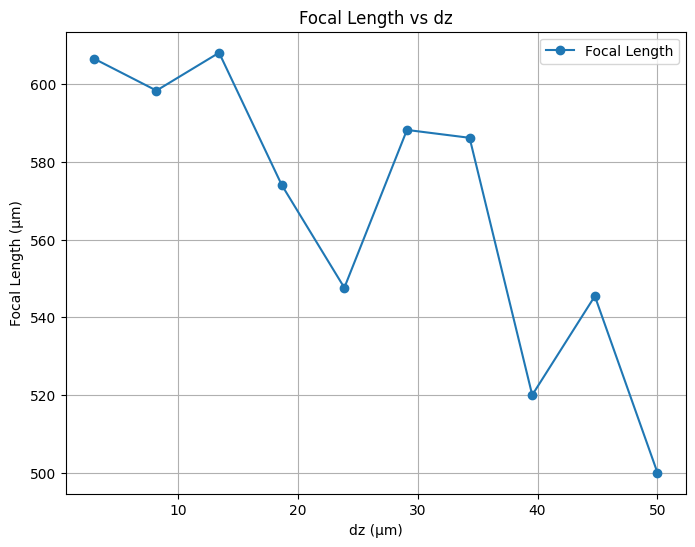

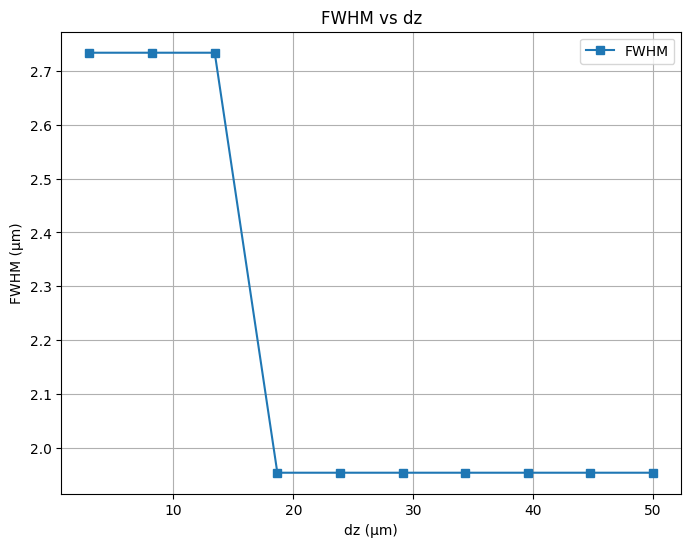

In [89]:
dz_values = np.linspace(3e-6, 50e-6, 10)  # Range of dz values
prop_distance_grin = 0.18e-3
n_max = 1.1
alpha = 1e7
U0 = np.ones((num_pixels, num_pixels))

# Store focal lengths and FWHM for each dz value
focal_lengths = []
fwhm_values = []

def find_fwhm(intensity_line):
    max_val = np.max(intensity_line)
    half_max = max_val / 2
    above_half_max = np.where(intensity_line >= half_max)[0]
    if len(above_half_max) > 1:
        fwhm = (above_half_max[-1] - above_half_max[0]) * dx * 1e6  # Convert to micrometers
    else:
        fwhm = np.nan  # Handle case where FWHM is not well-defined
    return fwhm

for dz in dz_values:
    prop_steps = np.round(1e-3 / dz).astype(int)
    prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)
    
    # Run propagation
    grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin, grin_dist, True)
    array_3d = np.stack(grating_zs)
    
    intensity = np.abs(array_3d[:, 256, :])**2
    max_value = np.max(intensity)
    max_index = np.unravel_index(np.argmax(intensity), intensity.shape)
    
    
    # Compute focal length
    focal_length = max_index[0] / prop_steps * prop_distance * 1e6
    focal_lengths.append(focal_length)
    
    
    # Compute intensity in the x-y plane and find max
    intensity_xy = np.abs(array_3d[max_index[0], :, :])**2  # Intensity at focal plane in x-y plane
    max_index = np.unravel_index(np.argmax(intensity_xy), intensity_xy.shape)
    

    # Compute FWHM at max_index in the x-direction
    fwhm = find_fwhm(intensity_xy[:, max_index[1]])
    fwhm_values.append(fwhm)

# Plot focal length vs dz
plt.figure(figsize=(8, 6))
plt.plot(dz_values * 1e6, focal_lengths, marker='o', label="Focal Length")
plt.xlabel("dz (µm)")
plt.ylabel("Focal Length (µm)")
plt.title("Focal Length vs dz")
plt.legend()
plt.grid()
plt.show()

# Plot FWHM vs dz
plt.figure(figsize=(8, 6))
plt.plot(dz_values * 1e6, fwhm_values, marker='s', label="FWHM")
plt.xlabel("dz (µm)")
plt.ylabel("FWHM (µm)")
plt.title("FWHM vs dz")
plt.legend()
plt.grid()
plt.show()
